<head style = "position:absolute; left:0px" class = "lse_header">
    <div style="width: 15%; float:left; height:100px;">
        <img src = "https://www.dropbox.com/s/mz416p4rrm692ed/lse_logo.png?raw=1" style="width: 100px; height: 35px; float:left; margin-top: 30px">
    </div>
    <div style="width: 70%; float:left; height:100px;">
        <h4 style = "text-align:center;margin-top: 30px;">FM442: Quantitative Methods for Finance and Risk Analysis</h4>
    </div>
    <div style="width: 15%; float:left; height:100px;">
        <p style = "text-align:right;margin-top:30px">Jon Danielsson<br>
    Michaelmas Term 2020</p>
    </div>
</head>

<h1 style = "text-align: center; font-size: 36px">Seminar 4</h1>

In this class we will:  

[1. Build univariate GARCH models](#1)  
[2. Plot the outputs](#2)    
[3. Work with various GARCH specifications](#3)  
[4. Relax the GARCH stationarity condition](#4)  
[5. Assess model quality using likelihood ratio tests and residual analysis](#5)  
[6. Learn about half-life and GARCH simulations](#6)

___
### Loading packages

We first load the packages for this seminar:

In [2]:
library(rugarch)
library(tseries)
library(car)

___
<a name="1"></a>
## Univariate GARCH models

In this class we will work with the GARCH family, which was originally proposed in 1982 by Robert Engle. Most volatility models used in industry nowadays derive from this formulation.

Returns have a **conditional** distribution, which we will initially assume to be normal:

$$Y_{t} \sim \mathcal{N}\left(0,\sigma_t^2\right)$$

Which can be written as: $Y_t = \sigma_{t}Z_{t}$, where $Z_{t} \sim \mathcal{N}\left(0,1\right)$. $Z_t$ is called **residual**.

The $\textrm{GARCH}\left(L_1,L_2\right)$ model is:

$$\sigma_t^2 = \omega + \sum_{i=1}^{L_1}\alpha_{i}Y^2_{t-i} + \sum_{j=1}^{L_2}\beta_{j}\sigma^2_{t-j}$$

Where:  
$\alpha$ is news.  
$\beta$ is memory.  
The size of $\left(\alpha + \beta\right)$ determines how quickly the predictability of the process dies out. 

We are going to use the J.P. Morgan returns from our `Y.RData` file to run various GARCH type models discussed in Chapter 2.

In [3]:
# Load the data
load("Y.RData")

# Save the returns in a variable called y
y <- Y$JPM

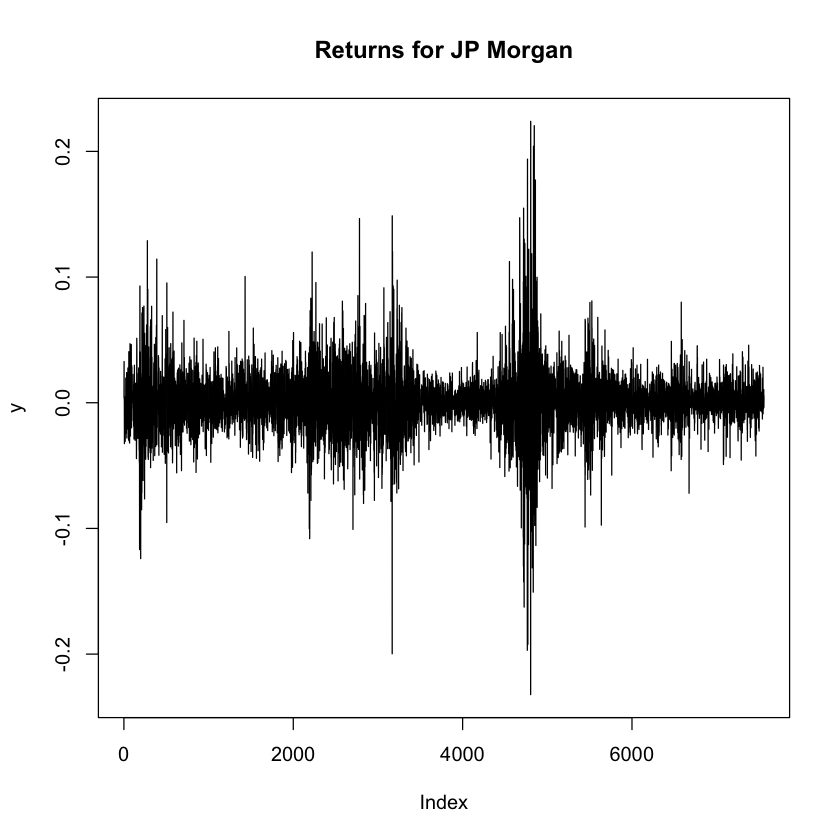

In [4]:
# Simple plot
plot(y, type = "l", main = "Returns for JP Morgan")

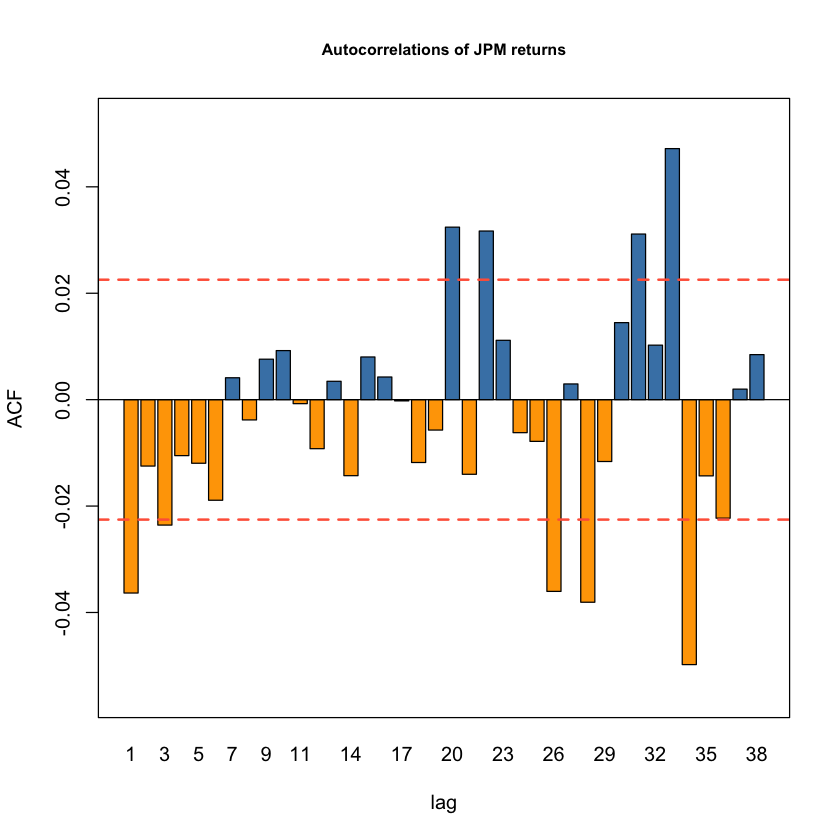

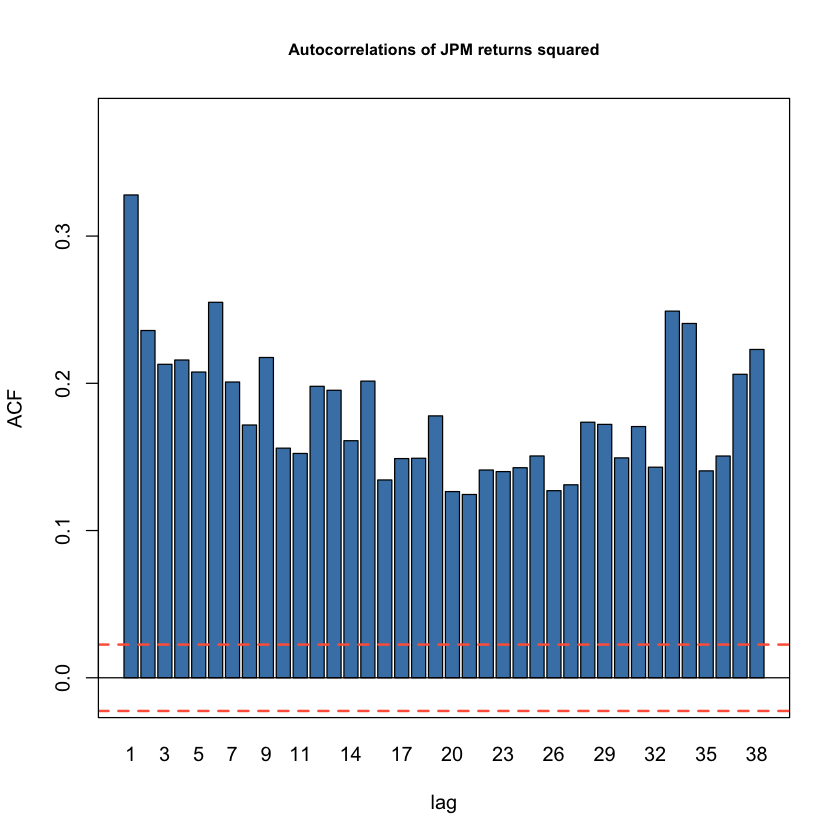

In [5]:
# Autocorrelations
source("acf_fm442.R")
acf_fm442(y, main = "Autocorrelations of JPM returns")
acf_fm442(y^2, main = "Autocorrelations of JPM returns squared")

The autocorrelation of the returns squared are significant for every lag, meaning that we see a behavior that can be modeled with GARCH.

We will use the `rugarch` library for building univariate GARCH models. The documentation for it can be found here: https://cran.r-project.org/web/packages/rugarch/rugarch.pdf

To build a univariate GARCH model, we first specify the type of GARCH model. 

### GARCH model specification

We can specify the type of GARCH model we want to fit using the `ugarchspec()` function. For example, we can specify the number of lags, if the model includes leverage or power effects, whether the mean should be included or not, and the conditional distribution of the returns. The common syntax we will use inside ` ugarchspec()` is:

Type of model: `variance.model = list(model = "type of model"),`  
Whether to include or not a mean: `mean.model = list(armaOrder = c(0,0), include.mean = FALSE),`  
Type of conditiona distribution: `distribution.model = "std"`

To get a detailed explanation on how to use all the options of `ugarchspec()`, you can type `?ugarchspec` in the console.

### Default GARCH

First we will run the default version, which is a conditionally normal GARCH(1,1) model with non-zero mean which follows an ARMA(1,1) process:

In [6]:
# Create the specifications
default_spec <- ugarchspec()

In [7]:
# We can call the variable to see what's inside
default_spec


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(1,0,1)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 


Once we have specified the model, we can fit our data into it using `ugarchfit()`:

In [8]:
# Fit the model to the data using ugarchfit
default_garch <- ugarchfit(spec = default_spec, data = y)

In [9]:
# Call the variable
default_garch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000780    0.000129      6.0548  0.00000
ar1     0.986601    0.002568    384.2263  0.00000
ma1    -0.991540    0.000030 -33441.3465  0.00000
omega   0.000002    0.000002      1.3651  0.17223
alpha1  0.065173    0.011878      5.4869  0.00000
beta1   0.931240    0.012200     76.3326  0.00000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000780    0.000866     0.90146  0.36734
ar1     0.986601    0.018888    52.23363  0.00000
ma1    -0.991540    0.000322 -3077.02735  0.00000
omega   0.000002    0.000014     0.16560  0.86847
alpha1  0.065173    0.093117     0.69991  0.48398
beta1   0.931240

The function provides comprehensive information on the model fit. It includes the optimal parameters estimates, standard errors, tests for significance, likelihood, information criteria, and several other tests.

Since this is too much information in the same place, we can tell R what particular information we are interested in. By using the `@` symbol we can extract the contents from an object. For example, by running:

In [10]:
# Check the content of default_garch
names(default_garch@fit)

[1] "hessian"         "cvar"            "var"             "sigma"          
 [5] "condH"           "z"               "LLH"             "log.likelihoods"
 [9] "residuals"       "coef"            "robust.cvar"     "A"              
[13] "B"               "scores"          "se.coef"         "tval"           
[17] "matcoef"         "robust.se.coef"  "robust.tval"     "robust.matcoef" 
[21] "fitted.values"   "convergence"     "kappa"           "persistence"    
[25] "timer"           "ipars"           "solver"

We see all the content provided by the `ugarchfit()` function. We can access any element of this list by using the `$` sign:

In [11]:
# Extract a particular element
default_garch@fit$coef

mu           ar1           ma1         omega        alpha1 
 7.802130e-04  9.866014e-01 -9.915404e-01  2.265294e-06  6.517320e-02 
        beta1 
 9.312401e-01

Another way of accessing this information is:

In [12]:
# Extracting coefficients with coef()
coef(default_garch)

mu           ar1           ma1         omega        alpha1 
 7.802130e-04  9.866014e-01 -9.915404e-01  2.265294e-06  6.517320e-02 
        beta1 
 9.312401e-01

Let's say we are particularly interesting in $\omega$. We can access it by:

In [13]:
# Accessing omega using its index
coef(default_garch)[4]

omega 
2.265294e-06

However, using the name instead of the index can prevent potential mistakes in our code (for example, if the package is updated and the list reordered):

In [14]:
# Accessing omega using its name
coef(default_garch)["omega"]

omega 
2.265294e-06

We can view the likelihood of the fitted model with:

In [15]:
likelihood(default_garch)

[1] 19593.57

Since we are mostly interested in the coefficients and the likelihood of a fitted GARCH model, we are going to use a function that only outputs this information instead of calling the object and getting the other non-essential details. This function is called `garch_fm442()` and is inside the `garch_fm442.R` file:

In [16]:
# Importing function that only outputs what we are interested in
source("garch_fm442.R")

# Call it
garch_fm442(default_garch)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters with Robust S.E.:
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000780    0.000866     0.90146  0.36734
ar1     0.986601    0.018888    52.23363  0.00000
ma1    -0.991540    0.000322 -3077.02735  0.00000
omega   0.000002    0.000014     0.16560  0.86847
alpha1  0.065173    0.093117     0.69991  0.48398
beta1   0.931240    0.096954     9.60499  0.00000

LogLikelihood : 19593.57 


___
<a name="2"></a>
## Plotting the GARCH output

A very useful feature of `rugarch` package is plotting. If we call the function `plot()` on a fitted GARCH model like `default_garch`, the following interactive menu will appear:

    Make a plot selection (or 0 to exit): 

    1.   Series with 2 Conditional SD Superimposed
    2.   Series with 1% VaR Limits
    3.   Conditional SD (vs |returns|)
    4.   ACF of Observations
    5.   ACF of Squared Observations
    6.   ACF of Absolute Observations
    7.   Cross Correlation
    8.   Empirical Density of Standardized Residuals
    9.   QQ-Plot of Standardized Residuals
    10.  ACF of Standardized Residuals
    11.  ACF of Squared Standardized Residuals
    12.  News-Impact Curve
    
We can visualize any of the plots by selecting the corresponding number. The plots for the `default_garch` are:

<div style = "display: flex;">
    <strong>1</strong> 
    <img src = "https://www.dropbox.com/s/078bup7zzcb9ejs/garch_1.png?raw=1" style = "width: 30%; height: auto;">
    <strong>2</strong> 
    <img src = "https://www.dropbox.com/s/xrkoo3jjtdohrrz/garch2.png?raw=1" style = "width: 30%; height:auto;">
    <strong>3</strong> 
    <img src = "https://www.dropbox.com/s/4upoyan2v83z0di/garch3.png?raw=1" style = "width: 30%; height:auto;">
</div>
<div style = "display: flex;">
    <strong>4</strong>
    <img src = "https://www.dropbox.com/s/j1nybwnc45jfbc2/garch4.png?raw=1" style = "width: 30%;">
    <strong>5</strong>
    <img src = "https://www.dropbox.com/s/26ccqhduc3rkf19/garch5.png?raw=1" style = "width: 30%;">
    <strong>6</strong>
    <img src = "https://www.dropbox.com/s/cscgv83nc9xp8g4/garch6.png?raw=1" style = "width: 30%;">
</div>
<div style = "display: flex;">
    <strong>7</strong>
    <img src = "https://www.dropbox.com/s/i32hs014v0rqrsa/garch7.png?raw=1" style = "width: 30%;">
    <strong>8</strong>
    <img src = "https://www.dropbox.com/s/s97fx4i6dt0uedy/garch8.png?raw=1" style = "width: 30%;">
    <strong>9</strong>
    <img src = "https://www.dropbox.com/s/o4gp8omlbszr0b3/garch9.png?raw=1" style = "width: 30%;">
</div>
<div style = "display: flex;">
    <strong>10</strong>
    <img src = "https://www.dropbox.com/s/c68emact9xb5mgq/garch10.png?raw=1" style = "width: 30%;">
    <strong>11</strong>
    <img src = "https://www.dropbox.com/s/59ipg3per1ib7dg/garch11.png?raw=1" style = "width: 30%;">
    <strong>12</strong>
    <img src = "https://www.dropbox.com/s/j7lcy4zdz0c1o1n/garch12.png?raw=1" style = "width: 30%;">
</div>

These plots provide us with plenty of information to analyze the fit and results of our model. For example, from Plot 8 and Plot 9 we can see that the distribution of residuals in our model does not correctly fit under a normal distribution. As expected, there is an excess of observations around the mean in the histogram in Plot 8, and in Plot 9 we see the presence of fat tails in our observations.

A key output of the GARCH model is the estimated conditional volatities, the sequence $\sigma_t$. This sequence is used for generating the first three plots shown above. We can access the sequence through `default_garch@fit$sigma`.

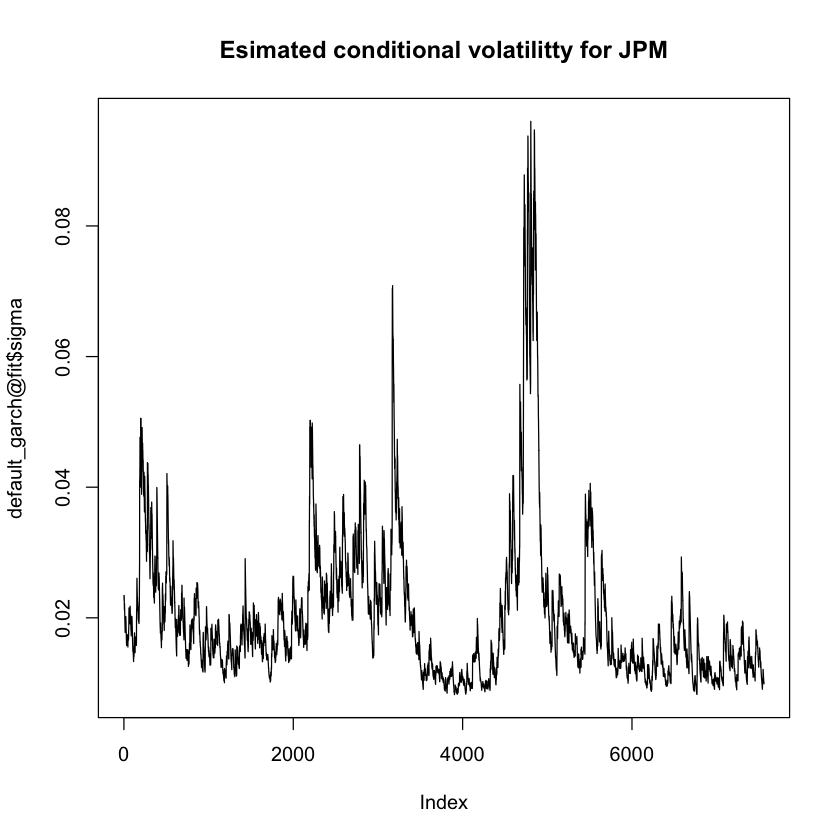

In [17]:
# Plotting the estimated conditional volatility
plot(default_garch@fit$sigma, type = "l", main = "Esimated conditional volatilitty for JPM")

___
<a name="3"></a>
## Other GARCH specifications

So far we have used the default specifications of `ugarchspec()`. Now we will build different models of the GARCH family using the same data. 

### GARCH(1,1) with no mean

The default method assumes that the mean of the GARCH process follows an ARMA(1,1) process. For the purpose of this class, we will use the assumption that the mean of the returns is equal to zero. To specify we don't want to include a mean in the model, we have to change the options in `mean.model`:

In [18]:
# New specification
spec1 <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Fit the model
GARCH <- ugarchfit(spec = spec1, data = y)

We can call the object to see the output. We will see that the coefficients now only include $\omega, \alpha_1, \beta_1$

In [19]:
garch_fm442(GARCH)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters with Robust S.E.:
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000002    0.000009  0.24103  0.80953
alpha1  0.063637    0.076755  0.82910  0.40705
beta1   0.932878    0.079043 11.80214  0.00000

LogLikelihood : 19578.86 


### ARCH(1)

An $\textrm{ARCH}\left(L_1\right)$ model is the restricted version of $\textrm{GARCH}$. Conditional volatility is modelled as a weighted average of past returns:

$$\sigma_t^2 = \omega + \sum_{i=1}^{L_1}\alpha_{i}Y^2_{t-i}$$

We can easily fit our data to an $\textrm{ARCH}\left(L_1\right)$ model by setting the second parameter in the $\textrm{GARCH}$ to $0$.

Models from the GARCH family are fitted using a Maximum Likelihood method, which requires a solver. We recommend using `solver = "hybrid"` if the algorithm fails to converge:

In [20]:
# Specification for ARCH(1)
spec2 <- ugarchspec(
    variance.model = list(garchOrder = c(1,0)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Fit to the data
ARCH <- ugarchfit(spec = spec2, data = y, solver = "hybrid")

In [21]:
garch_fm442(ARCH)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters with Robust S.E.:
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000313    0.000025  12.6315        0
alpha1  0.475085    0.063698   7.4584        0

LogLikelihood : 18408.31 


### Student-t GARCH

To take fat tails into account in our modelling, we can change the assumptions for the conditional distribution of the returns. The Student-t distribution is a natural choice since it shows fatter tails than the Normal distribution. This can be very useful in risk forecasting, but it requires at least 3,000 observations for a correct estimation.

For a Student-t GARCH we will use the assumption:

$$Z_t \sim t_{\left(\nu\right)}$$

Where $\nu$ is the degrees of freedom of the Student-t.

To implement it using R we use the `distribution.model` in `ugarchspec()`:

In [22]:
# Specify tGARCH
spec3 <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE),
    distribution.model = "std"
)

# Fit the model
tGARCH <- ugarchfit(spec = spec3, data = y)

When calling `tGARCH`, we will see that there is a new parameter called `shape`, which is the estimation of the degrees of freedom of the distribution:

In [23]:
coef(tGARCH)

omega       alpha1        beta1        shape 
2.024253e-06 7.231870e-02 9.264920e-01 6.044980e+00

To see how the `tGARCH` fits our data better than the `GARCH` model, we can see Plot 8 and Plot 9 for `tGARCH`:

<div style = "display: flex;">
    <strong>Plot 8</strong> 
    <img src = "https://www.dropbox.com/s/g2qiduk6un2fkbu/tgarch1.png?raw=1" style = "width: 45%; height:auto;">
    <strong>Plot 9</strong> 
    <img src = "https://www.dropbox.com/s/ov5dzsqpmwapiz4/tgarch2.png?raw=1" style = "width: 45%; height:auto;">
</div>

In Plot 8 we can see how the Student-t distribution is a better fit for our data compared to the Normal distribution. It has a higher peak around zero, which matches what we see in financial data. In Plot 9, the qqPlot, we see a better fit for extreme values, due to the fat-tailed nature of the Student-t distribution.

### Asymmetric power GARCH - APARCH

The $\textrm{APARCH}$ model takes into account both leverage effects and power effects. A leverage effect can be present since stock returns are sometimes negatively correlated with changes in volatility. Power models take into consideration that absolute returns might have stronger autocorrelations than squared returns. APARCH takes this into account. Here is the model with one lag:

$$\sigma^2_t=\omega+\alpha \ \left(\mid Y_{t-1}\mid - \ \gamma \ Y_{t-1} \right)^{\delta}+ \beta \ \sigma^{\delta}_{t-1}$$

The model allows for leverage effects when $\zeta \neq 0$ and power effects when $\delta \neq 2$. This model is usually difficult to estimate since it requires at least 4,000 observations.

We can specify this model in the `variance.model` option in `ugarchspec()`:

In [24]:
# Specify APARCH model
spec4 <- ugarchspec(
    variance.model = list(model = "apARCH"),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Fit to the data
apARCH <- ugarchfit(spec = spec4, data = y)

In the coefficients we will find the estimation for $\gamma$and $\delta$

In [25]:
# View the coefficients
coef(apARCH)

omega       alpha1        beta1       gamma1        delta 
6.334229e-05 6.583413e-02 9.386669e-01 4.864971e-01 1.260309e+00

### APARCH model with fat tails

We can include a Student-t distribution in the APARCH model to account for fat tails:

In [26]:
# Specify tapARCH model
spec5 <- ugarchspec(
    variance.model = list(model = "apARCH"),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE),
    distribution.model = "std"
)

# Fit to the data
tapARCH <- ugarchfit(spec = spec5, data = y)

In [27]:
garch_fm442(tapARCH)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: apARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters with Robust S.E.:
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000068    0.000067   1.0232 0.306201
alpha1  0.076841    0.026362   2.9149 0.003558
beta1   0.932121    0.028227  33.0218 0.000000
gamma1  0.487157    0.153840   3.1666 0.001542
delta   1.223021    0.341307   3.5833 0.000339
shape   6.400247    0.473885  13.5059 0.000000

LogLikelihood : 19858.52 


### News impact curve

The news impact curve measures how new information affects the return volatility in GARCH models. Intuitively, it tells us how a shock to returns in period $t-1$ will affect volatility in period $t$. For standard GARCH models, it has a symmetric U-shape, the reason being that for the estimation we are using returns squared, so it won't matter if the news are positive or negative.

Asymmetric GARCH models like the apARCH react differently if the news are positive or negative. Generally, negative news increase volatility more than positive news, so the U shape will not be symmetrical. The plot below shows the news impact curve for the GARCH, tGARCH, apARCH and tapARCH models we created:

![News_impact](https://www.dropbox.com/s/vf9mndgqkolhm24/news_impact.png?raw=1)

___
<a name="4"></a>
## GARCH Stationarity

The unconditional volatility for a GARCH(1,1) model is:

$$\sigma^2 = \frac{\omega}{1-\alpha-\beta}$$ 

To ensure positive volatility forecasts, we need:

$$\omega, \alpha, \beta \geq 0$$ 

It is a common question if we should impose $\alpha + \beta < 1$, which determines if the process has variance stationarity or not. This is not advisable except in special circumstances for two reasons:

* Can lead to multiple parameter combinations satisfying the constraint so volatility forecasts can be non-unique
* Model is misspecified anyways and the non-restricted coule give more accurate forecasts+

By default, `ugarchfit()` imposes stationarity in the model, but we can relax this assumption using the option: `fit.control = list(stationarity = 0)`. For example, we will use a subset of the data to fit a stationary and a non-stationary model:

In [28]:
# Subset the data
subset <- y[4000:5000]

spec <- ugarchspec()

# Stationary GARCH - Default
stationary_GARCH <- ugarchfit(spec = spec, data = subset)

# Non-stationary GARCH - using fit.control = list(stationarity = 0)
non_stationary_GARCH <- ugarchfit(spec = spec, data = subset, fit.control = list(stationarity = 0))

# Compare alpha + beta
cat("Stationary alpha + beta:", sum(coef(stationary_GARCH)[c("alpha1", "beta1")]), "\n",
   "Nonstationary alpha + beta:", sum(coef(non_stationary_GARCH)[c("alpha1", "beta1")]))

Stationary alpha + beta: 0.9989996 
 Nonstationary alpha + beta: 1.013637

If we plot the fitted conditional volatilities we will see that they look very similar:

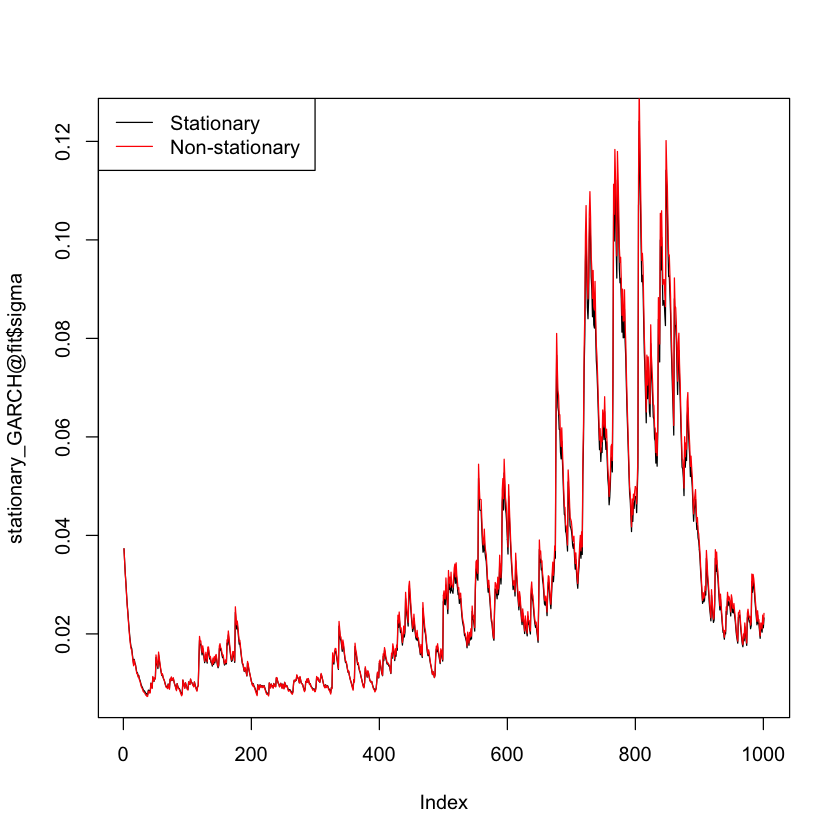

In [29]:
plot(stationary_GARCH@fit$sigma, type = "l", col = "black")
lines(non_stationary_GARCH@fit$sigma, col="red")
legend("topleft", legend = c("Stationary", "Non-stationary"), lty = 1, col = c("black", "red"))

However, they are not exactly the same:

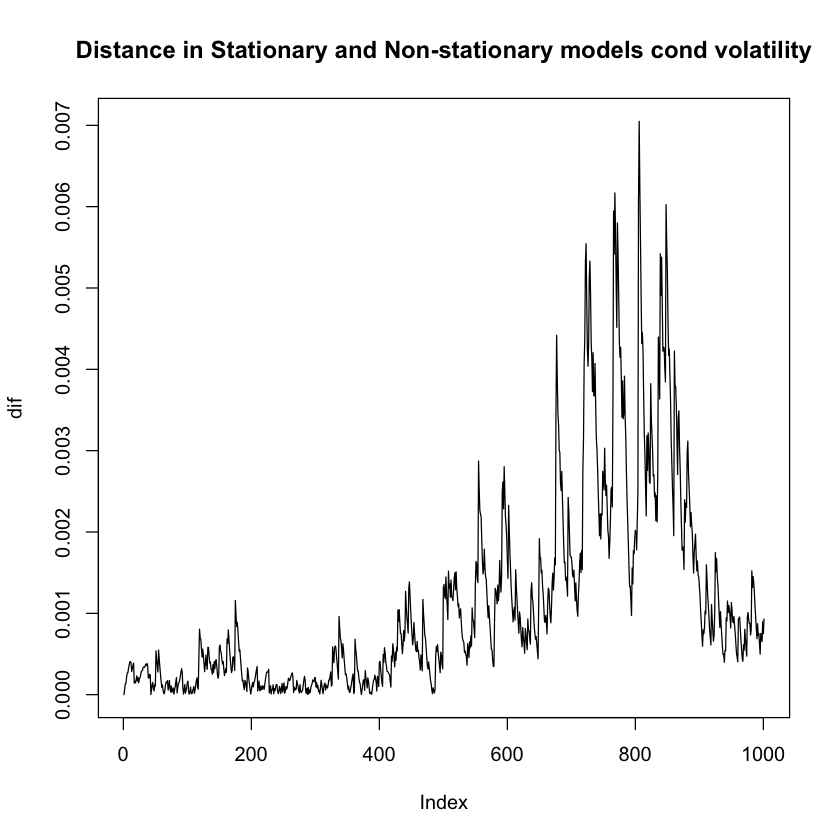

In [30]:
# Create a new variable with the absolute difference between stationary and non-stationary
dif <- abs(stationary_GARCH@fit$sigma - non_stationary_GARCH@fit$sigma)

# Plot it
plot(dif, type = "l", main = "Distance in Stationary and Non-stationary models cond volatility")

The distance between the estimated conditional volatility of the stationary and non-stationary model resembles the shape of the estimated conditional volatility.

___
<a name="5"></a>
## Assess Models and Testing

### Summary of our models

The following table summarizes the coefficients for the models we have built, including the log-likelihood:


|       | ARCH | GARCH | tGARCH | apARCH | apARCH |
|:-----:| :-----: | :-----: | :-----: | :-----: | :-----: |
| $\omega$ | 0.00031 | 2.20394e-06 | 2.02425e-06 | 6.33423e-05 | 6.82302e-05 |
| $\alpha$ | 0.47508 | 0.06364 | 0.07232 | 0.06583 | 0.07684 |
| $\beta$ | - | 0.93288 | 0.92649 | 0.93867 | 0.93212 |
| $\nu$ | - | - | 6.04498 | - | 6.40025 |
| $\gamma$ | - | - | - | 0.48650 | 0.48716 |
| $\delta$ | - | - | - | 1.26031 | 1.22302 |
| $\textrm{Likelihood}$ | 18408 | 19579 | 19787 | 19669 | 19859 |

### Likelihood ratio test

Consider two models, where one is nested inside the other. This can be the case of the $\textrm{ARCH(1)}$, which is a subset of a $\textrm{GARCH(1,1)}$. We can call the nested model _restricted_ (R), and the other _unrestricted_ (U).

By definition:
$$\log \mathcal{L}_R \leq \mathcal{L}_U$$

Two times the difference between the unrestricted and restricted likelihood is distributed as a $\chi^2$ with degrees of freedom equal to the number of restrictions:

$$\textrm{LR} = 2\left(\mathcal{L}_U - \mathcal{L}_R\right) \sim \chi^2_{\left(\textrm{number of restrictions}\right)}$$

The _number of restrictions_ means how many parameters we are excluding in the _restricted_ model. For example, if we consider the ARCH vs GARCH models:

In [36]:
# Number of restrictions ARCH vs GARCH
coef(ARCH)
coef(GARCH)

omega       alpha1 
0.0003131761 0.4750852779

omega       alpha1        beta1 
2.203944e-06 6.363749e-02 9.328776e-01

The ARCH model, nested inside the GARCH model, has one parameter less. So in this case the _number of restrictions_ which serves as the degrees of freedom in the chi-square distribution, would be one.

In the case of the ARCH vs the tGARCH model:

In [37]:
# Number of restrictions ARCH vs tGARCH
coef(ARCH)
coef(tGARCH)

omega       alpha1 
0.0003131761 0.4750852779

omega       alpha1        beta1        shape 
2.024253e-06 7.231870e-02 9.264920e-01 6.044980e+00

The ARCH model has two parameters while the tGARCH has four, so we would be dealing with two degrees of freedom.

We can easily implement the LR test using the `likelihood` output from the `ugarchfit()` function.

Let's perform the test for the ARCH(1) and GARCH(1,1) models we created:

In [38]:
# Creating the LR statistic - using cat() for output display
cat(" Likelihood of ARCH: ", round(likelihood(ARCH),2), "\n", 
    "Likelihood of GARCH: ", round(likelihood(GARCH),2), "\n",
   "2 * (Lu - Lr): ", round(2*(likelihood(GARCH)-likelihood(ARCH)),2))

 Likelihood of ARCH:  18408.31 
 Likelihood of GARCH:  19578.86 
 2 * (Lu - Lr):  2341.11

The value of the test statistic is 2341. How do we know if this is above the critical value for a Chi-square with one degree of freedom and a confidence level of 95%?

We can use the `qchisq()` function to find the 95% quantile of the Chi-square.

In [39]:
# 95% quantile of chi-square
qchisq(p = 0.95, df = 1)

[1] 3.841459

The critical value is 3.84, which is smaller than 2341. This means we have enough evidence to reject that the two models perform similarly.

We can also use `pchisq()` to find the p-value of the test statistic:

In [40]:
# Adding the p-value
p.value  <- 1 - pchisq(2*(likelihood(GARCH)-likelihood(ARCH)), df = 1)
cat(" Likelihood of ARCH: ", round(likelihood(ARCH),2), "\n", 
    "Likelihood of GARCH: ", round(likelihood(GARCH),2), "\n",
   "2 * (Lu - Lr): ", round(2*(likelihood(GARCH)-likelihood(ARCH)),2), "\n",
   "p-value:", p.value)

 Likelihood of ARCH:  18408.31 
 Likelihood of GARCH:  19578.86 
 2 * (Lu - Lr):  2341.11 
 p-value: 0

We can create a `Test()` function that takes two fitted models and gives an output with the likelihoods and p-values:

In [41]:
# Creating a function for Likelihood Tests
Test <- function(restricted, unrestricted) {
    
    # Specifying the degrees of freedom as the number of restrictions
    df <- length(unrestricted@fit$coef) - length(restricted@fit$coef)
    
    # Creating the statistic
    lr <- 2*(likelihood(unrestricted) - likelihood(restricted))
    
    # Finding its p-value
    p.value <- 1 - pchisq(lr, df)
    
    # Output
    cat("Degrees of freedom:", df, "\n",
        "Likelihood of unrestricted model:", likelihood(unrestricted), "\n",
        "Likelihood of restricted model:", likelihood(restricted), "\n",
        "LR: 2*(Lu-Lr):", lr, "\n",
        "p-value:", p.value
       )
}

Using our new `Test()` function, let's test the GARCH and tapARCH models:

In [42]:
# Testing the GARCH and tapARCH
Test(GARCH, tapARCH)

Degrees of freedom: 3 
 Likelihood of unrestricted model: 19858.52 
 Likelihood of restricted model: 19578.86 
 LR: 2*(Lu-Lr): 559.3062 
 p-value: 0

### Residual Analysis

We have assumed returns to be conditionally normally distributed. We can test this with a Jarque-Bera test for normality and a Ljung-Box test for autocorrelation of returns and returns-squared, and do a QQ plot to see the fit. 

Let's perform this test with the output of our GARCH(1,1) model:

In [43]:
# Performing residual analysis
residuals <- GARCH@fit$residuals

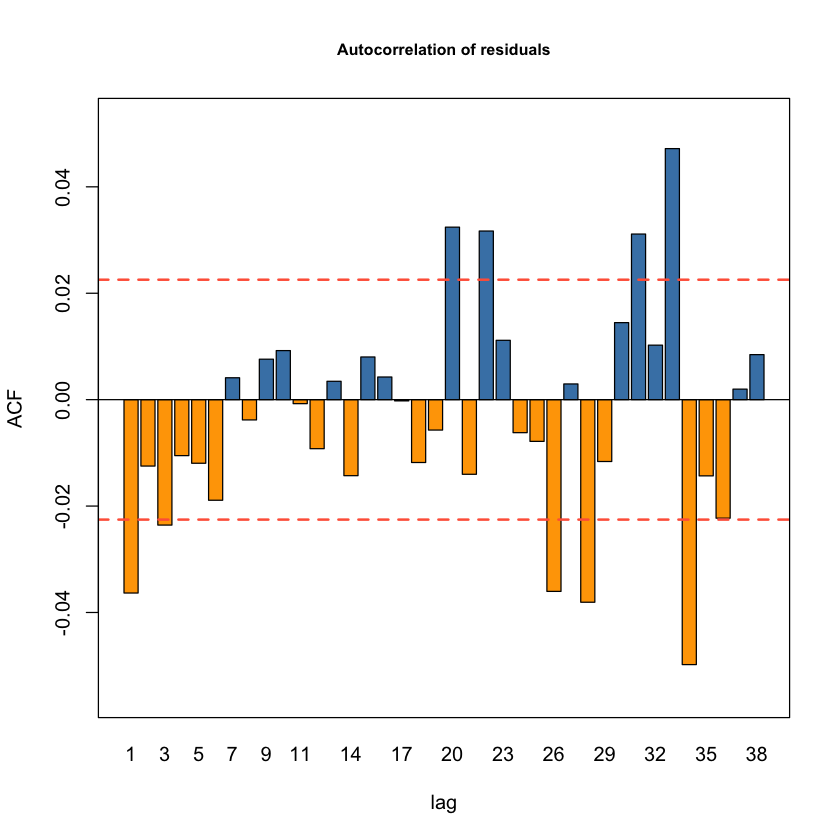

In [45]:
# Autocorrelation of residuals
acf_fm442(residuals, main = "Autocorrelation of residuals")

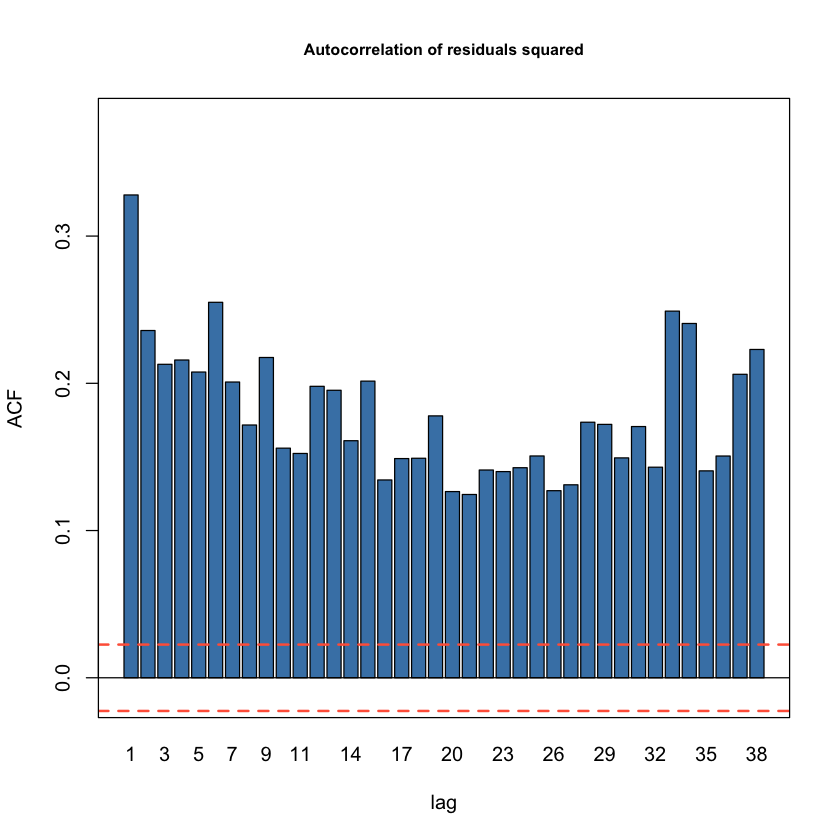

In [47]:
# Autocorrelation of residuals squared
acf_fm442(residuals^2, main = "Autocorrelation of residuals squared")

In [48]:
# Jarque-Bera test for Normality
jarque.bera.test(residuals)


	Jarque Bera Test

data:  residuals
X-squared = 43342, df = 2, p-value < 2.2e-16


In [49]:
# Ljung-Box test for residuals
Box.test(residuals, type = "Ljung-Box")


	Box-Ljung test

data:  residuals
X-squared = 9.9875, df = 1, p-value = 0.001576


In [50]:
# Ljung-Box test for residuals squared
Box.test(residuals^2, type = "Ljung-Box")


	Box-Ljung test

data:  residuals^2
X-squared = 813.18, df = 1, p-value < 2.2e-16


[1] 4803 4804

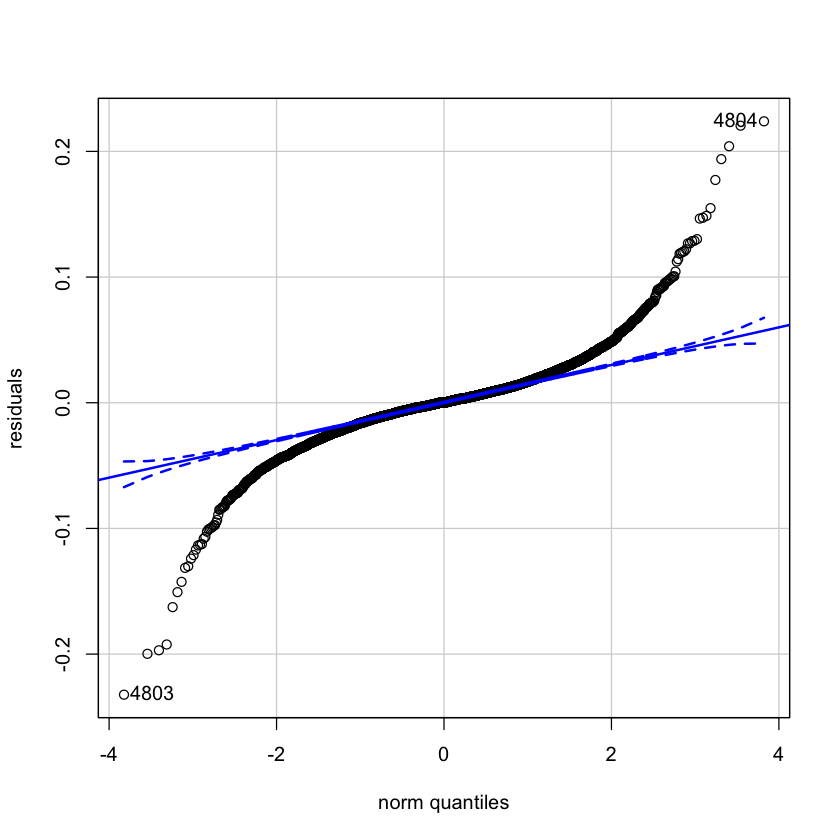

In [51]:
# qqPlot for residuals under a normal distribution
qqPlot(residuals)

[1] 4803 4804

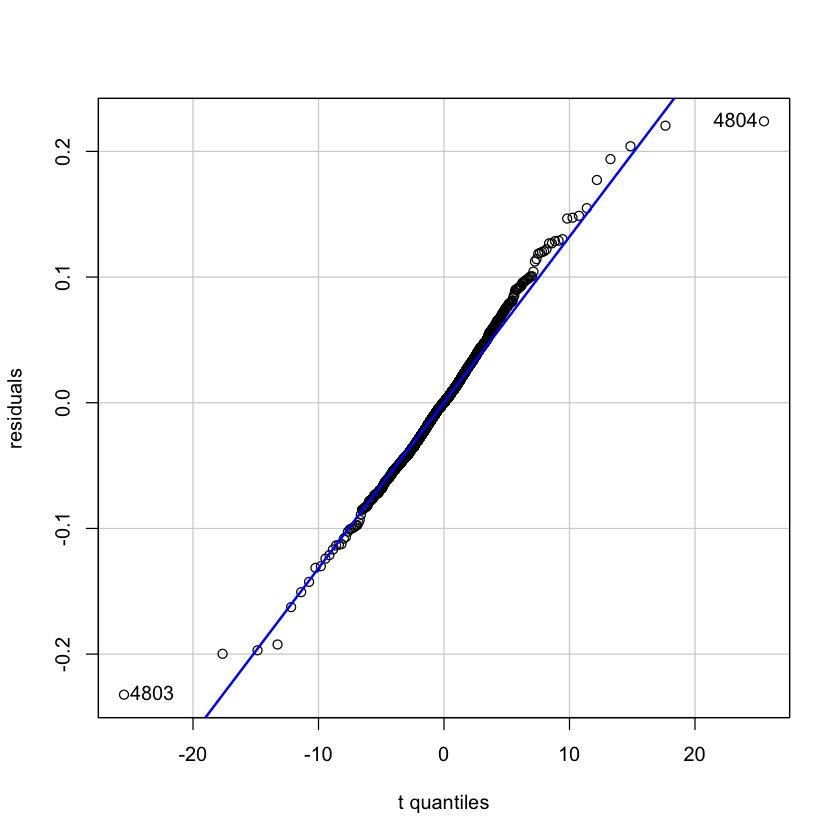

In [52]:
# qqPlot for residuals under a Student-t with 3 degrees of freedom
qqPlot(residuals, distribution = "t", df = 3, envelope = FALSE)

___
<a name="6"></a>
## Half-life and simulations

### Half-life

We are interested in how quickly shocks die out to understand the memory present in the data. The _half-life_ is defined as the number of periods, $n^*$, it takes for conditional variance to revert back halfway towards unconfitional variance:
$$\sigma^2_{t+n^*,t} - \sigma^2 = \frac{1}{2}\left(\sigma^2_{t+1,t}-\sigma^2\right)$$  
$$\left(\alpha + \beta \right)^{n^*-1} \left(\sigma^2_{t+1,t}-\sigma^2\right) = \frac{1}{2}\left(\sigma^2_{t+1,t}-\sigma^2\right)$$  
$$n^* = 1 + \frac{\log\left(\frac{1}{2}\right)}{\log\left(\alpha + \beta \right)}$$ 

So, as $\left(\alpha + \beta \right) \rightarrow 1$, $n^* \rightarrow \infty$, the memory is infinite. We can easily calculate the _half-life_ from our model:

In [53]:
# Half-life
# We use unname() to remove the names of the objects
alpha <- unname(coef(GARCH)['alpha1'])
beta <- unname(coef(GARCH)['beta1'])
half_life <- 1 + (log(0.5)/log(alpha+beta))
cat("The Half-life for our GARCH(1,1) is", half_life, "time periods.")

The Half-life for our GARCH(1,1) is 199.5518 time periods.

### Simulations

The package `rugarch` allows us to use the function `ugarchsim()` to simulate series using the fitted model. Since simulations involve the use of random numbers, every simulation will be different from each other (unless we specify seeds for replicability).

As a exercise, we can do 1000 simulations using our GARCH(1,1) model and use the `matplot()` function to see how our simulated returns and volatility would look like:

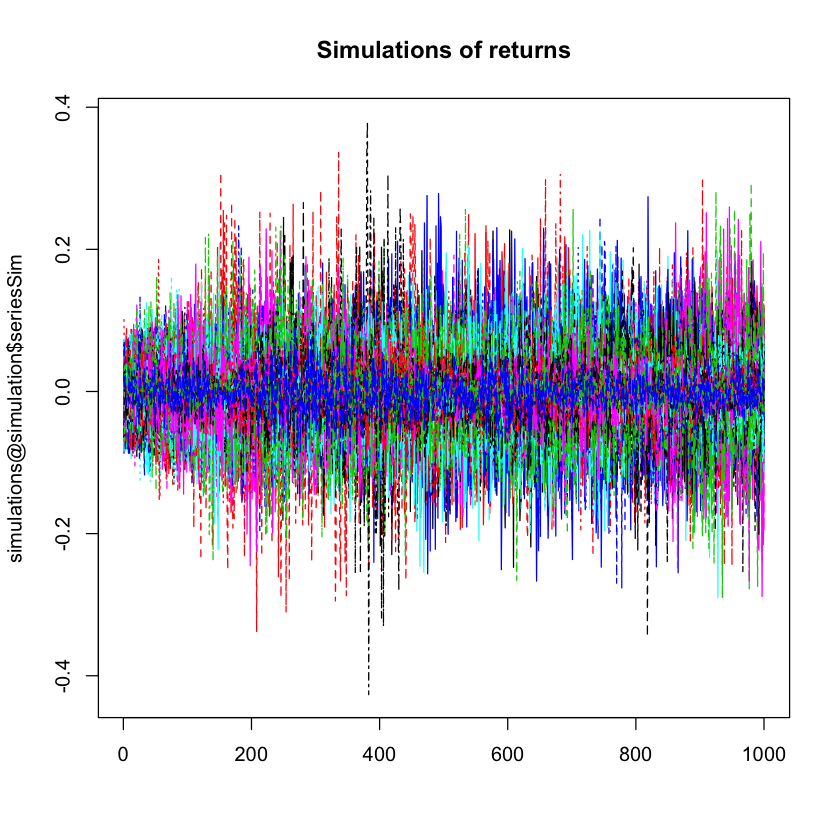

In [54]:
# Create 1000 simulations from our fitted model
simulations <- ugarchsim(GARCH, m.sim = 1000)

# Plot the simulated returns
matplot(simulations@simulation$seriesSim, type = "l",
       main = "Simulations of returns")

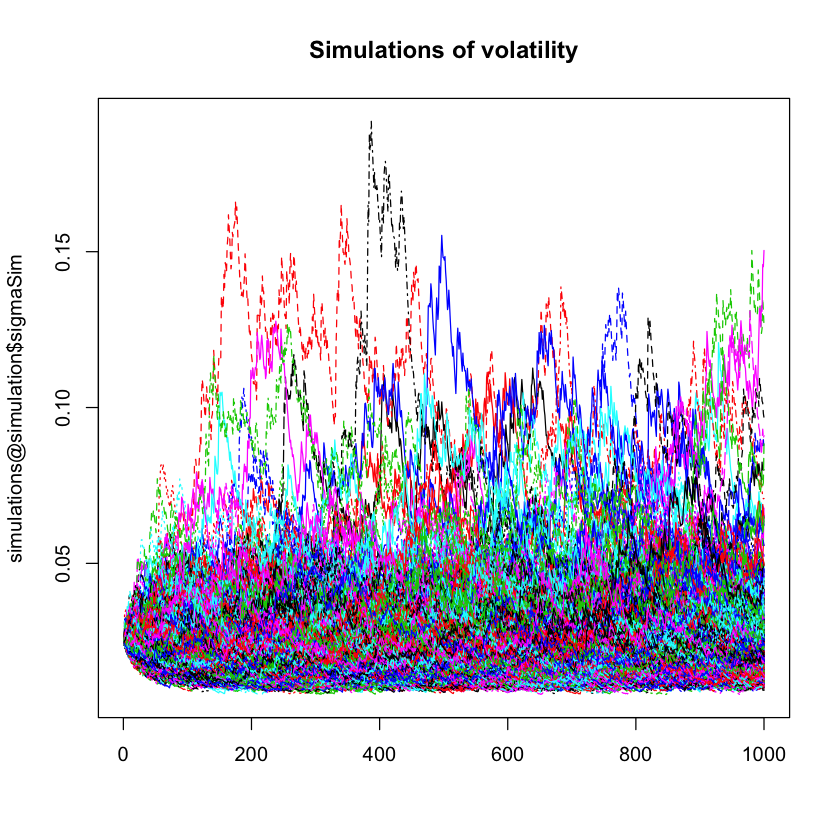

In [55]:
# Plot the simulated volatilities
matplot(simulations@simulation$sigmaSim, type = "l", 
       main = "Simulations of volatility")

### Monte-Carlo simulation

We can take advantage of `ugarchsim()` to do a quick Monte Carlo study. We know the coefficients of our model are:

In [56]:
coef(GARCH)

omega       alpha1        beta1 
2.203944e-06 6.363749e-02 9.328776e-01

We can fit a GARCH model to every simulation of returns, store the coefficients, and see how they are distributed and the relationship to the true coefficients. The law of large numbers tells us that for a large number of simulations, the distribution should converge to the true values:

In [58]:
# Number of simulations
sim <- 1000

# Create vectors to hold the fitted parameters
omega_sim <- vector(length = sim)
alpha_sim <- vector(length = sim)
beta_sim <- vector(length = sim)

# Specify the GARCH we will use
spec <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Create the simulations
simulations <- ugarchsim(GARCH, m.sim = sim)

# Fit a GARCH for every simulation and store the parameter values
for (i in 1:sim) {
    # Fit the GARCH model
    temp <- ugarchfit(spec = spec1, data = simulations@simulation$seriesSim[,i])
    # Add parameters to vectors created
    omega_sim[i] <- unname(coef(temp)['omega'])
    alpha_sim[i] <- unname(coef(temp)['alpha1'])
    beta_sim[i] <- unname(coef(temp)['beta1'])
}

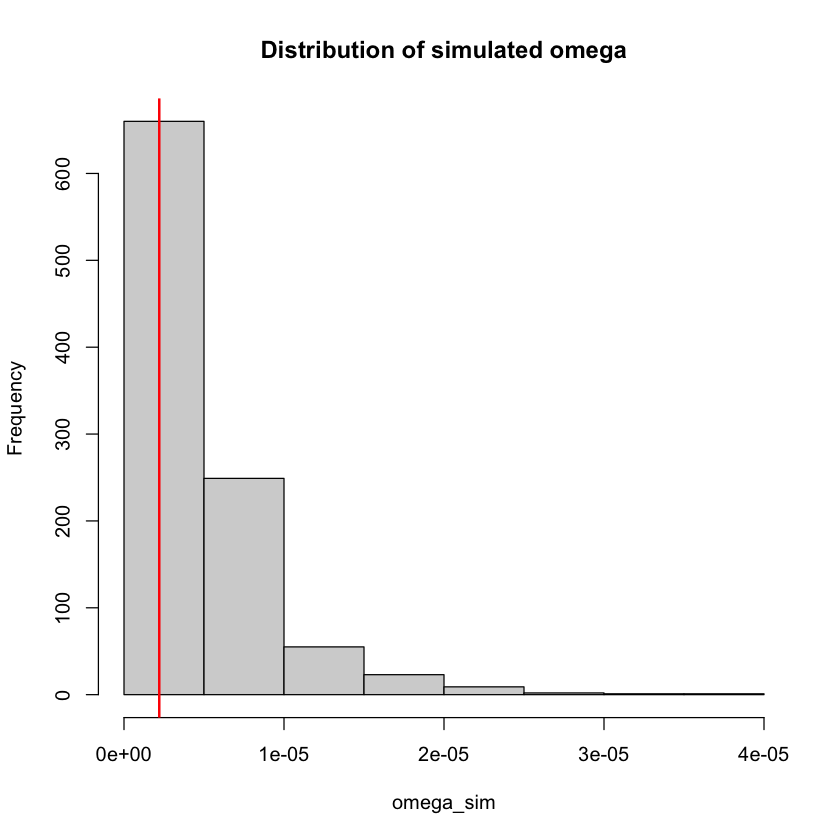

In [59]:
# Omega

# Distribution
hist(omega_sim, col = "lightgray", main = "Distribution of simulated omega")

# Adding a vertical line on the true parameter
abline(v = coef(GARCH)['omega'], col = "red", lwd = 2)

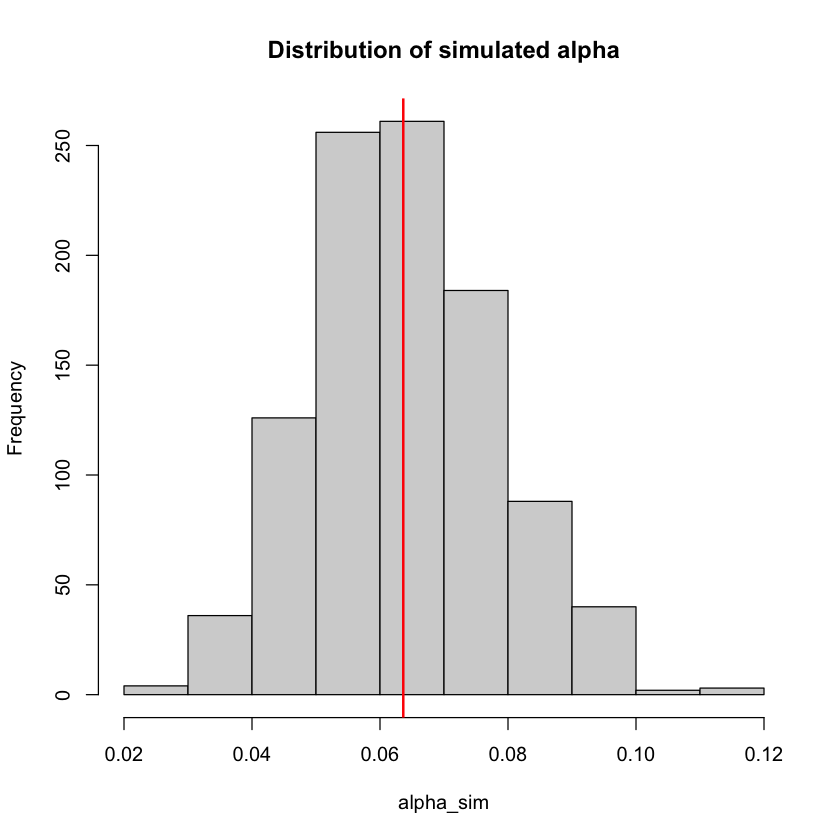

In [60]:
# Alpha

# Distribution
hist(alpha_sim, col = "lightgray", main = "Distribution of simulated alpha")

# Adding a vertical line on the true parameter
abline(v = coef(GARCH)['alpha1'], col = "red", lwd = 2)

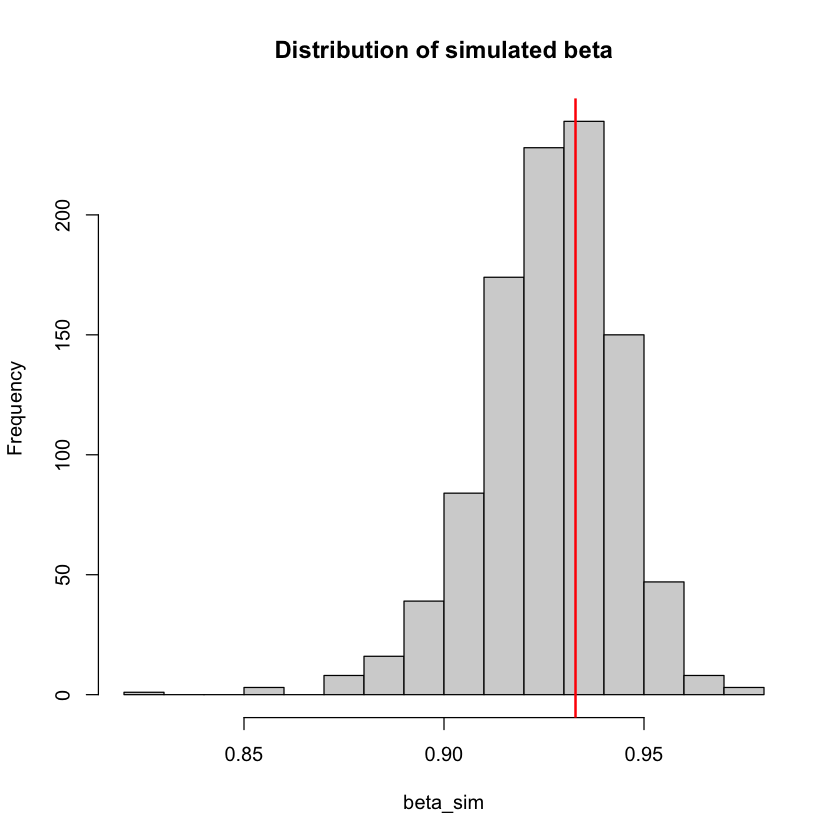

In [61]:
# Beta

# Distribution
hist(beta_sim, col = "lightgray", main = "Distribution of simulated beta")

# Adding a vertical line on the true parameter
abline(v = coef(GARCH)['beta1'], col = "red", lwd = 2)

## Recap

In this seminar we have covered:

* Building univariate GARCH models using R
* Accessing the output of a fitted GARCH model
* Plotting GARCH output
* Fitting ARCH, tARCH, apARCH and tapARCH models
* Performing Likelihood ratio tests
* Creating a function
* Doing residual analysis
* Half-life 
* Simulations with fitted GARCH models
* Monte Carlo experiment for GARCH
* Variance stationarity

Some new functions used:

* `ugarchspec()`
* `ugarchfit()`
* `ugarchsim()`
* `coef()`
* `likelihood()`
* `cat()`
* `function()`

For more discussion on the material covered in this seminar, refer to _Chapter 2: Univariate volatility modeling_ on _Financial Risk Forecasting_ by Jon Danielsson.

<small> Acknowledgements: Thanks to Alvaro Aguirre for creating these notebooks</small>  
<small> © Jon Danielsson, 2020 </small>